## TO DO:
* check if confidence of the model is true, also for submodels 
* 

In [99]:
import sys, os
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models
softmax = torch.nn.Softmax(dim=1)
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import (
    top_k_accuracy_score,
    classification_report,
    confusion_matrix
)
import random
from pathlib import Path
from tqdm import tqdm
from transformers import SegformerFeatureExtractor, SegformerForSemanticSegmentation
from typing import List, Tuple
import torch.nn.functional as F

In [72]:
# Compute absolute path to the `src/` folder
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))
SRC_PATH     = os.path.join(PROJECT_ROOT, "src")

if SRC_PATH not in sys.path:
    sys.path.insert(0, SRC_PATH)

from utils import get_dataloaders, load_model, evaluate_model, print_metrics, plot_confusion_matrix, show_sample_predictions, plot_random_image_with_label_and_prediction

In [14]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

In [114]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print("Using device:", device)

Using device: mps


In [10]:
COUNTRIES = ["Albania","Andorra","Argentina","Australia","Austria","Bangladesh","Belgium","Bhutan","Bolivia","Botswana","Brazil","Bulgaria","Cambodia","Canada","Chile","Colombia","Croatia","Czechia","Denmark","Dominican Republic","Ecuador","Estonia","Eswatini","Finland","France","Germany","Ghana","Greece","Greenland","Guatemala","Hungary","Iceland","Indonesia","Ireland","Israel","Italy","Japan","Jordan","Kenya","Kyrgyzstan","Latvia","Lesotho","Lithuania","Luxembourg","Malaysia","Mexico","Mongolia","Montenegro","Netherlands","New Zealand","Nigeria","North Macedonia","Norway","Palestine","Peru","Philippines","Poland","Portugal","Romania","Russia","Senegal","Serbia","Singapore","Slovakia","Slovenia","South Africa","South Korea","Spain","Sri Lanka","Sweden","Switzerland","Taiwan","Thailand","Turkey","Ukraine","United Arab Emirates","United Kingdom","United States","Uruguay"]
num_classes = len(COUNTRIES)
project_root   = Path().resolve().parent

### Data

In [146]:
test_root = project_root/ "data" / "final_datasets" / "test"
test_loader = get_dataloaders(test_root, batch_size=32)

### Load model

In [282]:
model = load_model(model_path=project_root / "models" / "resnet_finetuned" / "main.pth", device=device)

/Users/michelangelonardi/Desktop/Università/Master/Bocconi Master/Year 1/Semester2/Computer Vision & Image processing/Final - project/rainbot/src/utils.py:225: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues relate

### Get base model prediction probs

In [149]:
def get_prob(true_lbl, probs_i, class_names, n=5):
    topk     = probs_i.argsort()[::-1][:3]
    class_names = np.array(class_names)
    topk_str = ", ".join(f"{class_names[k]} ({probs_i[k]:.2f})" for k in topk)
    print(f"True: {true_lbl:20s}  ↔  Pred Top-3: {topk_str}")

In [158]:
# get random image 
all_countries = [d for d in test_root.iterdir() if d.is_dir()]
country = random.choice(all_countries).name
img_files = list((test_root / country).glob("*.jpg"))
img_path = random.choice(img_files)

img = Image.open(img_path).convert("RGB")

# Preprocess and predict
input_tensor = transform(img).unsqueeze(0).to(device)  # add batch dimension
with torch.no_grad():
    outputs = model(input_tensor)
    pred_idx = outputs.argmax(dim=1).item()
    pred_label = COUNTRIES[pred_idx]

probs = softmax(outputs).cpu().numpy()

get_prob(country, np.squeeze(probs), COUNTRIES, n=1)

True: Chile                 ↔  Pred Top-3: Chile (0.17), Argentina (0.15), Croatia (0.12)


### Get segments

In [161]:
MODEL_NAME = "nvidia/segformer-b0-finetuned-cityscapes-768-768"

feature_extractor = SegformerFeatureExtractor.from_pretrained(MODEL_NAME)
seg_model = SegformerForSemanticSegmentation.from_pretrained(MODEL_NAME).eval()

/opt/anaconda3/envs/cv_env/lib/python3.10/site-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/opt/anaconda3/envs/cv_env/lib/python3.10/site-packages/transformers/models/segformer/feature_extraction_segformer.py:28: FutureWarning: The class SegformerFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use SegformerImageProcessor instead.
  warnings.warn(
/opt/anaconda3/envs/cv_env/lib/python3.10/site-packages/transformers/models/segformer/image_processing_segformer.py:103: FutureWarning: The `reduce_labels` parameter is deprecated and will be removed in a future version. Please use `do_reduce_labels` instead.
  warnings.warn(


In [254]:
CITYSCAPES_LABELS = {
    0: 'road', 
    8: 'vegetation',  9: 'terrain'
}

TARGET_CLASSES = {'road','terrain','vegetation'}

In [255]:
def segment_image_per_class(
    image: Image.Image
) -> List[Tuple[str, Image.Image]]:
    """
    Runs semantic segmentation on `image` and returns a list of
    (class_name, masked_image) for each detected class in TARGET_CLASSES.
    Each masked_image is black everywhere except pixels of that class.
    """
    # 1) Preprocess
    inputs = feature_extractor(images=image, return_tensors="pt")
    with torch.no_grad():
        outputs = seg_model(**inputs)
    logits = outputs.logits  # shape: (1, num_classes, H, W)
    
    # 2) Argmax to get predicted label per pixel
    pred = torch.argmax(logits.squeeze(), dim=0).cpu().numpy()  # shape: (H, W)
    
    h, w = pred.shape
    img_np = np.array(image.resize((w, h)))  # align sizes
    
    results = []
    for label_id, class_name in CITYSCAPES_LABELS.items():
        if class_name not in TARGET_CLASSES:
            continue
        mask = (pred == label_id)
        if not mask.any():
            continue  # this class not present
        
        # Create a blank canvas
        canvas = np.zeros_like(img_np)
        # Copy only masked pixels
        canvas[mask] = img_np[mask]
        masked_img = Image.fromarray(canvas)
        results.append((class_name, masked_img))
    
    return results

In [256]:
segments = segment_image_per_class(img)

for class_name, seg_img in segments:
    print("Found:", class_name)
    seg_img.show()

Found: road
Found: vegetation
Found: terrain


In [302]:
segments

[('road', <PIL.Image.Image image mode=RGB size=128x128>),
 ('vegetation', <PIL.Image.Image image mode=RGB size=128x128>),
 ('terrain', <PIL.Image.Image image mode=RGB size=128x128>)]

In [257]:
# plot segmented images 
def plot_segmented_images(image: Image.Image, segments: List[Tuple[str, Image.Image]]):
    fig, axes = plt.subplots(1, len(segments) + 1, figsize=(15, 5))
    axes[0].imshow(image)
    axes[0].set_title("Original Image")
    axes[0].axis("off")
    
    for ax, (class_name, seg_img) in zip(axes[1:], segments):
        ax.imshow(seg_img)
        ax.set_title(class_name)
        ax.axis("off")
    
    plt.tight_layout()
    plt.show()

### Call submodels 

In [ ]:
def classify_segments(segments):
    """
    segments: List of (class_name, PIL.Image) from segment_image_per_class.
    For each, loads ../models/resnet_finetuned_{class_name}/main.pth,
    infers top-5, and prints results.
    """
    for class_name, img in segments:
        model_dir = os.path.join("..", "models", f"resnet_finetuned_{class_name}")
        weights_path = os.path.join(model_dir, "main.pth")
        if not os.path.exists(weights_path):
            print(f"[!] Missing model for {class_name} at {weights_path}")
            continue

        # 1) Load checkpoint and determine num_classes
        ckpt = torch.load(weights_path, map_location="cpu")
        state = ckpt.get('model_state') or ckpt.get('state_dict') or ckpt
        out_features = list(state.keys())[-2]  # e.g. 'fc.weight'
        # Extract weight tensor shape from checkpoint
        fc_weight = state['fc.weight']
        num_classes = fc_weight.shape[0]

        # 2) Build same ResNet and load weights
        clf = models.resnet50(pretrained=False)
        clf.fc = torch.nn.Linear(clf.fc.in_features, num_classes)
        clf.load_state_dict(state)
        clf.to(device).eval()

        # 3) Preprocess and run
        inp = transform(img).unsqueeze(0).to(device)
        with torch.no_grad():
            logits = clf(inp)
            probs = F.softmax(logits, dim=1).cpu().squeeze().numpy()

        return probs

### Example

In [288]:
# get random image 
all_countries = [d for d in test_root.iterdir() if d.is_dir()]
country = random.choice(all_countries).name
img_files = list((test_root / country).glob("*.jpg"))
img_path = random.choice(img_files)

img = Image.open(img_path).convert("RGB")

# Preprocess and predict
input_tensor = transform(img).unsqueeze(0).to(device)  # add batch dimension
with torch.no_grad():
    outputs = model(input_tensor)
    pred_idx = outputs.argmax(dim=1).item()
    pred_label = COUNTRIES[pred_idx]

probs = softmax(outputs).cpu().numpy()

get_prob(country, np.squeeze(probs), COUNTRIES, n=1)

True: Taiwan                ↔  Pred Top-3: Taiwan (0.80), Thailand (0.14), Japan (0.03)


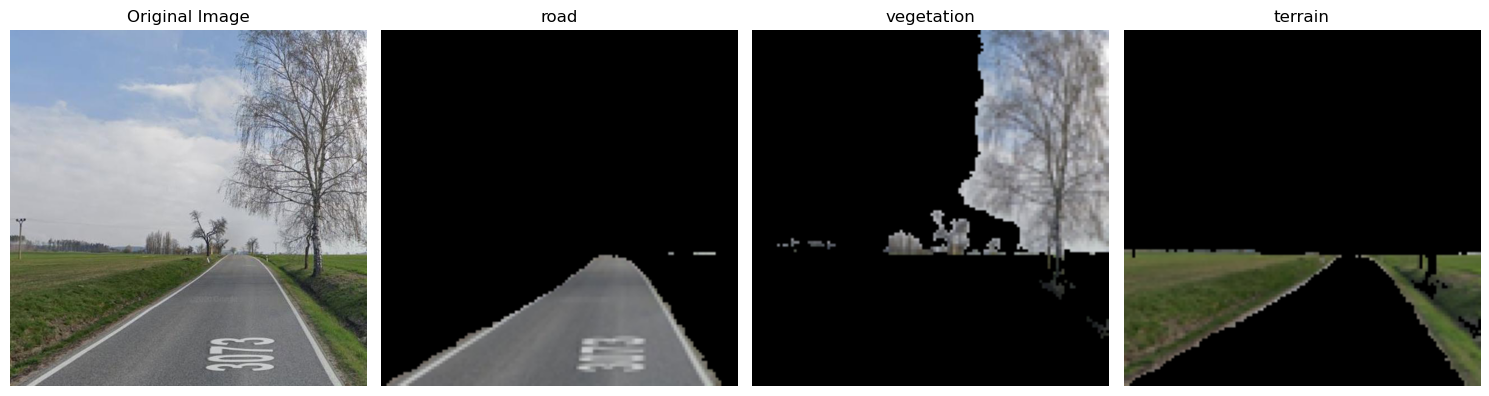

In [279]:
segments = segment_image_per_class(img)
plot_segmented_images(img, segments)

In [280]:
classify_segments(segments)

/var/folders/d5/5853p9zd6pvbjb8vz92bhmnc0000gn/T/ipykernel_3578/1204377696.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(weights_path, map_location=


[road] Top-5 predictions:
  Bulgaria: 0.249
  Romania: 0.220
  Peru: 0.117
  Croatia: 0.072
  Slovakia: 0.067

[vegetation] Top-5 predictions:
  Iceland: 0.069
  Netherlands: 0.058
  Switzerland: 0.058
  Belgium: 0.056
  Ukraine: 0.054

[terrain] Top-5 predictions:
  Netherlands: 0.142
  Lithuania: 0.129
  Belgium: 0.068
  Sweden: 0.066
  Ukraine: 0.045


## evaluate confidence of models 

In [284]:
from sklearn.calibration import calibration_curve


def evaluate_confidence(model, test_loader, device, n_bins=10):
    """
    For each test example, record:
      - confidence = max softmax probability
      - correct? = (pred == true_label)
    Then:
      1) Plot reliability diagram
      2) Compute ECE
      3) Print accuracy at high-confidence thresholds
    """
    model.eval()
    confidences = []
    corrects    = []
    
    with torch.no_grad():
        for imgs, labels in test_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            logits = model(imgs)
            probs  = softmax(logits)
            maxp, preds = probs.max(dim=1)
            
            confidences.extend(maxp.cpu().numpy())
            corrects.extend((preds == labels).cpu().numpy())

    confidences = np.array(confidences)
    corrects    = np.array(corrects, dtype=int)
    
    # 1) Reliability diagram (calibration curve)
    frac_pos, mean_pred = calibration_curve(corrects, confidences, n_bins=n_bins, strategy='uniform')
    plt.figure(figsize=(6,6))
    plt.plot(mean_pred, frac_pos, 's-', label='Model')
    plt.plot([0,1],[0,1],'--', color='gray', label='Perfectly calibrated')
    plt.xlabel('Mean predicted confidence (bin)')
    plt.ylabel('Empirical accuracy')
    plt.title('Reliability Diagram')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # 2) Expected Calibration Error (ECE)
    # ECE = sum_{b} |acc(b) - conf(b)| * |B_b|/N
    bin_edges = np.linspace(0,1,n_bins+1)
    ece = 0.0
    N = len(confidences)
    for i in range(n_bins):
        idx = (confidences >= bin_edges[i]) & (confidences < bin_edges[i+1])
        if idx.sum() == 0:
            continue
        acc_b  = corrects[idx].mean()
        conf_b = confidences[idx].mean()
        ece   += abs(acc_b - conf_b) * (idx.sum() / N)
    print(f"Expected Calibration Error (ECE): {ece:.4f}")

    # 3) Accuracy at high-confidence thresholds
    for thr in [0.9, 0.8, 0.7, 0.6]:
        idx = confidences >= thr
        if idx.sum() > 0:
            acc_thr = corrects[idx].mean()
            print(f"Accuracy for conf ≥ {int(thr*100)}%: {acc_thr:.4f} over {idx.sum()} samples")
        else:
            print(f"No samples with conf ≥ {int(thr*100)}%")

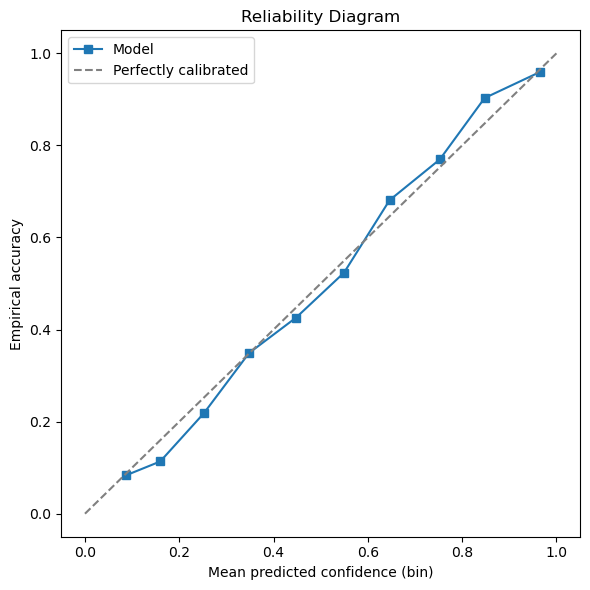

Expected Calibration Error (ECE): 0.0225
Accuracy for conf ≥ 90%: 0.9595 over 839 samples
Accuracy for conf ≥ 80%: 0.9443 over 1148 samples
Accuracy for conf ≥ 70%: 0.9073 over 1456 samples
Accuracy for conf ≥ 60%: 0.8709 over 1735 samples


In [285]:
evaluate_confidence(model, test_loader, device, n_bins=10)

In [295]:
def evaluate_submodels_confidence(
    test_root: Path,
    segment_fn,          # your segment_image_per_class
    classify_fn,         # a modified classify_segments that returns (pred_idx, confidence)
    device,
    n_bins: int = 10
):
    """
    test_root: Path to test images, organized per-country subfolders.
    segment_fn: function(image) -> [(class_name, PIL.Image), ...]
    classify_fn: function(class_name, PIL.Image) -> (pred_idx, confidence)
    device: torch.device
    """
    confidences = []
    corrects    = []

    # 1) Iterate all test images
    for country_dir in test_root.iterdir():
        if not country_dir.is_dir(): continue
        true_country = country_dir.name
        for img_path in country_dir.glob("*.jpg"):
            img = Image.open(img_path).convert("RGB")

            # 2) Segment into masked crops
            segments = segment_fn(img)

            # 3) For each segment, classify & record
            pred_idx, conf = classify_fn(segments)
            confidences.append(conf)
            
            # Was the top-1 country correct?
            is_correct = (COUNTRIES[pred_idx] == true_country)
            corrects.append(int(is_correct))

    confidences = np.array(confidences)
    corrects    = np.array(corrects)

    # 4) Calibration curve
    frac_pos, mean_pred = calibration_curve(corrects, confidences, n_bins=n_bins)
    plt.figure(figsize=(6,6))
    plt.plot(mean_pred, frac_pos, 's-', label='Segments')
    plt.plot([0,1],[0,1],'--', color='gray')
    plt.title('Reliability Diagram (Submodels)')
    plt.xlabel('Mean Predicted Confidence')
    plt.ylabel('Empirical Accuracy')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # 5) Expected Calibration Error (ECE)
    ece = 0.0
    N = len(confidences)
    bins = np.linspace(0,1,n_bins+1)
    for i in range(n_bins):
        idxs = (confidences >= bins[i]) & (confidences < bins[i+1])
        if idxs.sum() == 0: continue
        acc_b  = corrects[idxs].mean()
        conf_b = confidences[idxs].mean()
        ece   += abs(acc_b - conf_b) * (idxs.sum()/N)
    print(f"ECE (segments): {ece:.4f}")

    # 6) Accuracy at high-confidence thresholds
    for thr in [0.9, 0.8, 0.7, 0.6]:
        idxs = confidences >= thr
        if idxs.sum()>0:
            print(f"Acc for conf ≥{int(thr*100)}%: {corrects[idxs].mean():.4f} "
                  f"over {idxs.sum()} segments")
        else:
            print(f"No segments with conf ≥{int(thr*100)}%")

In [300]:
def classify_segment(segments):
    """
    segments: List of (class_name, PIL.Image) from segment_image_per_class.
    For each, loads ../models/resnet_finetuned_{class_name}/main.pth,
    infers top-5, and prints results.
    """
    for class_name, img in segments:
        model_dir = os.path.join("..", "models", f"resnet_finetuned_{class_name}")
        weights_path = os.path.join(model_dir, "main.pth")
        if not os.path.exists(weights_path):
            print(f"[!] Missing model for {class_name} at {weights_path}")
            continue

        # 1) Load checkpoint and determine num_classes
        ckpt = torch.load(weights_path, map_location="cpu")
        state = ckpt.get('model_state') or ckpt.get('state_dict') or ckpt
        out_features = list(state.keys())[-2]  # e.g. 'fc.weight'
        # Extract weight tensor shape from checkpoint
        fc_weight = state['fc.weight']
        num_classes = fc_weight.shape[0]

        # 2) Build same ResNet and load weights
        clf = models.resnet50(pretrained=False)
        clf.fc = torch.nn.Linear(clf.fc.in_features, num_classes)
        clf.load_state_dict(state)
        clf.to(device).eval()

        # 3) Preprocess and run
        inp = transform(img).unsqueeze(0).to(device)
        logits = clf(inp)
        probs  = softmax(logits).cpu().detach().numpy().squeeze()
        pred_idx = int(probs.argmax())
        confidence = float(probs[pred_idx])
        return pred_idx, confidence

In [301]:
evaluate_submodels_confidence(
    test_root,
    segment_image_per_class,
    classify_segment,
    device,
    n_bins=10
)

/var/folders/d5/5853p9zd6pvbjb8vz92bhmnc0000gn/T/ipykernel_3578/4195396565.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(weights_path, map_location=

KeyboardInterrupt: 